In [1]:
import os,glob
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
import pickle
import warnings  
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
warnings.filterwarnings("ignore")

In [2]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
path    = '/Volumes/home/Research/STEP/02_Station_result_csv'
remove  = '/Volumes/home/Research/STEP/05_Station_result_statistics/V4_Remove_catalog.txt'
figpath = '/Volumes/home/Research/STEP/12_PiercePoint'
smooth_fault='/Volumes/home/Research/DataBase/01_Armenia/00_smooth_fault_7.txt'
Afault='/Volumes/home/Research/DataBase/01_Armenia/00_A_fault_20220624.txt'
method = 'SC'
dr = pd.read_csv(remove,sep='\s+',names=['station','time','phase','a','b','c','d','e','f','g'])

PPdepth = [50,60,70,80,90,100]
if not os.path.isdir(f'{figpath}/non-null/Cluster{PPdepth}'):
    os.mkdir(f'{figpath}/non-null/Cluster{PPdepth}')

In [3]:
def PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep):
        
    cmd = """
    taup pierce -mod iasp91 -h %(evdep)f -sta %(stlat)f %(stlon)f -evt %(evlat)f %(evlon)f -ph %(phase)s --pierce %(PierceDep)f -nodiscon  > temp.txt
    """ % locals()
    os.system(cmd)

    if evdep > PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==2 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])
    elif evdep <= PierceDep:
        cmd = """
        cat temp.txt | awk 'NR==3 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        p_lat=float(text.rsplit(' ')[0])
        p_lon=float(text.rsplit(' ')[1][:-1])  
    
    return p_lon, p_lat

def PygmtBegin(figmap, region, title):
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    figmap.grdimage('@earth_relief_15s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=60)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
#     figmap.plot(data=smooth_fault,pen='1p,brown')
    Volcano = '/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
    dv = pd.read_csv(Volcano)
    figmap.plot(x=dv['lon'],y=dv['lat'],style="kvolcano/0.4c", pen='0.1p,black', color="black")

In [8]:
PPdepth = [100]
for PierceDep in PPdepth:
    newdf = {'station':[],
             'event':[],
             'phase':[],
             'plon':[],
             'plat':[],
             'phi':[],
             'dt':[]      }
    for pkl in sorted(glob.glob(f'{PKLpath}/*.pkl')):
        STApkl = pickle.load(open(pkl, "rb"))
        values = [value for keys, value in STApkl.items() ][0]
        sta = values['station'];net = values['network']
        if sta not in ['MAKU','DGRL','CMCY']:
            stlat = values['latitude']; stlon = values['longitude']
            for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/{net}.{sta}*result.csv')):
                df = pd.read_csv(resultpath)
                dff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]

                for i in range(len(dff)):
                    event = dff['Event'].values[i]
                    evlat = dff['Ev_lat'].values[i]
                    evlon = dff['Ev_lon'].values[i]
                    evdep = dff['Depth'].values[i]
                    phase = dff['Phase'].values[i]
                    if sta in dr['station'].to_list() and event in dr['time'].to_list():
                            print(f'{sta} {event}')
                    else:
                        phi = dff['SCPhi'].values[i]
                        dt  = dff['SCdt'].values[i]
                        if phase == 'SKS': color = 'red3'
                        elif phase == 'SKKS': color = 'violet'

                        p_lon, p_lat = PiercePoint(evdep, stlat, stlon, evlat, evlon, phase, PierceDep)

                        newdf['station'].append(sta)
                        newdf['event'].append(event)
                        newdf['phase'].append(phase)
                        newdf['plon'].append(p_lon)
                        newdf['plat'].append(p_lat)
                        newdf['phi'].append(phi)
                        newdf['dt'].append(dt)
                    
    newdf = pd.DataFrame(newdf)
    #=======for kmean ========
    print('=======start kmean')
    from sklearn.cluster import KMeans
    x=[]
    for lonn, latt in zip(newdf['plon'],newdf['plat']):
        x.append([lonn,latt])
    X = np.array(x)

    CLU={}
    kmeans = KMeans(n_clusters=48)
    kmeans_fit = kmeans.fit(X)
    label = (kmeans_fit.labels_).tolist()
    CLU['cluster'] = label
    CLU = pd.DataFrame(CLU)
    dc = pd.concat([newdf, CLU], axis=1)
    dc = dc.sort_values(by=['cluster'])
    dc.to_csv(f'{figpath}/non-null/PP{PierceDep}.csv', index=False)     
    print('=======end kmean')

VAND 20150123_034727
VAND 20190731_150233
VAND 20200805_120536
VAND 20160729_211826
VAND 20180211_231415
ZARN 20180211_231415
GUDG 20131123_074832
TBLG 20130523_210746
KIV 20140326_032936
KIV 20140708_125625
KIV 20170926_042000
KIV 20181223_230843
KIV 20110726_174421
KIV 20110909_194133
GNI 20131123_074832
GNI 20130514_003226
GNI 20180828_223513
GNI 20200613_210830
=======start kmean
=======end kmean
VAND 20150123_034727
VAND 20190731_150233
VAND 20200805_120536
VAND 20160729_211826
VAND 20180211_231415
ZARN 20180211_231415
GUDG 20131123_074832
TBLG 20130523_210746
KIV 20140326_032936
KIV 20140708_125625
KIV 20170926_042000
KIV 20181223_230843
KIV 20110726_174421
KIV 20110909_194133
GNI 20131123_074832
GNI 20130514_003226
GNI 20180828_223513
GNI 20200613_210830
=======start kmean
=======end kmean
VAND 20150123_034727
VAND 20190731_150233
VAND 20200805_120536
VAND 20160729_211826
VAND 20180211_231415
ZARN 20180211_231415
GUDG 20131123_074832
TBLG 20130523_210746
KIV 20140326_032936
KIV 

In [4]:
PPdepth = 100

In [5]:
df = pd.read_csv(f'{figpath}/non-null/PP{PPdepth}.csv')

In [6]:
df

station            event phase   plon   plat    phi   dt  cluster
0       AKH  20160725_172650   SKS  43.35  41.40  29.05  1.2        0
1       AKH  20140824_232143   SKS  43.33  41.42  56.00  1.2        0
2       AKH  20140824_232141   SKS  43.33  41.42  47.00  1.3        0
3       AKH  20140403_015829   SKS  43.34  41.41  46.61  1.1        0
4       AKH  20140323_182001   SKS  43.34  41.41  26.00  2.1        0
..      ...              ...   ...    ...    ...    ...  ...      ...
177     KIV  20120130_051059  SKKS  42.37  44.00  53.70  0.6       45
178     KIV  20160725_172650  SKKS  42.38  43.94  38.27  0.8       45
179     ONI  20121214_103601   SKS  43.40  42.74  13.00  0.7       46
180    URAV  20120428_100807  SKKS  43.54  42.73  89.89  1.2       46
181     QZX  20111117_015704   SKS  45.22  41.10  66.23  0.7       47

[182 rows x 8 columns]

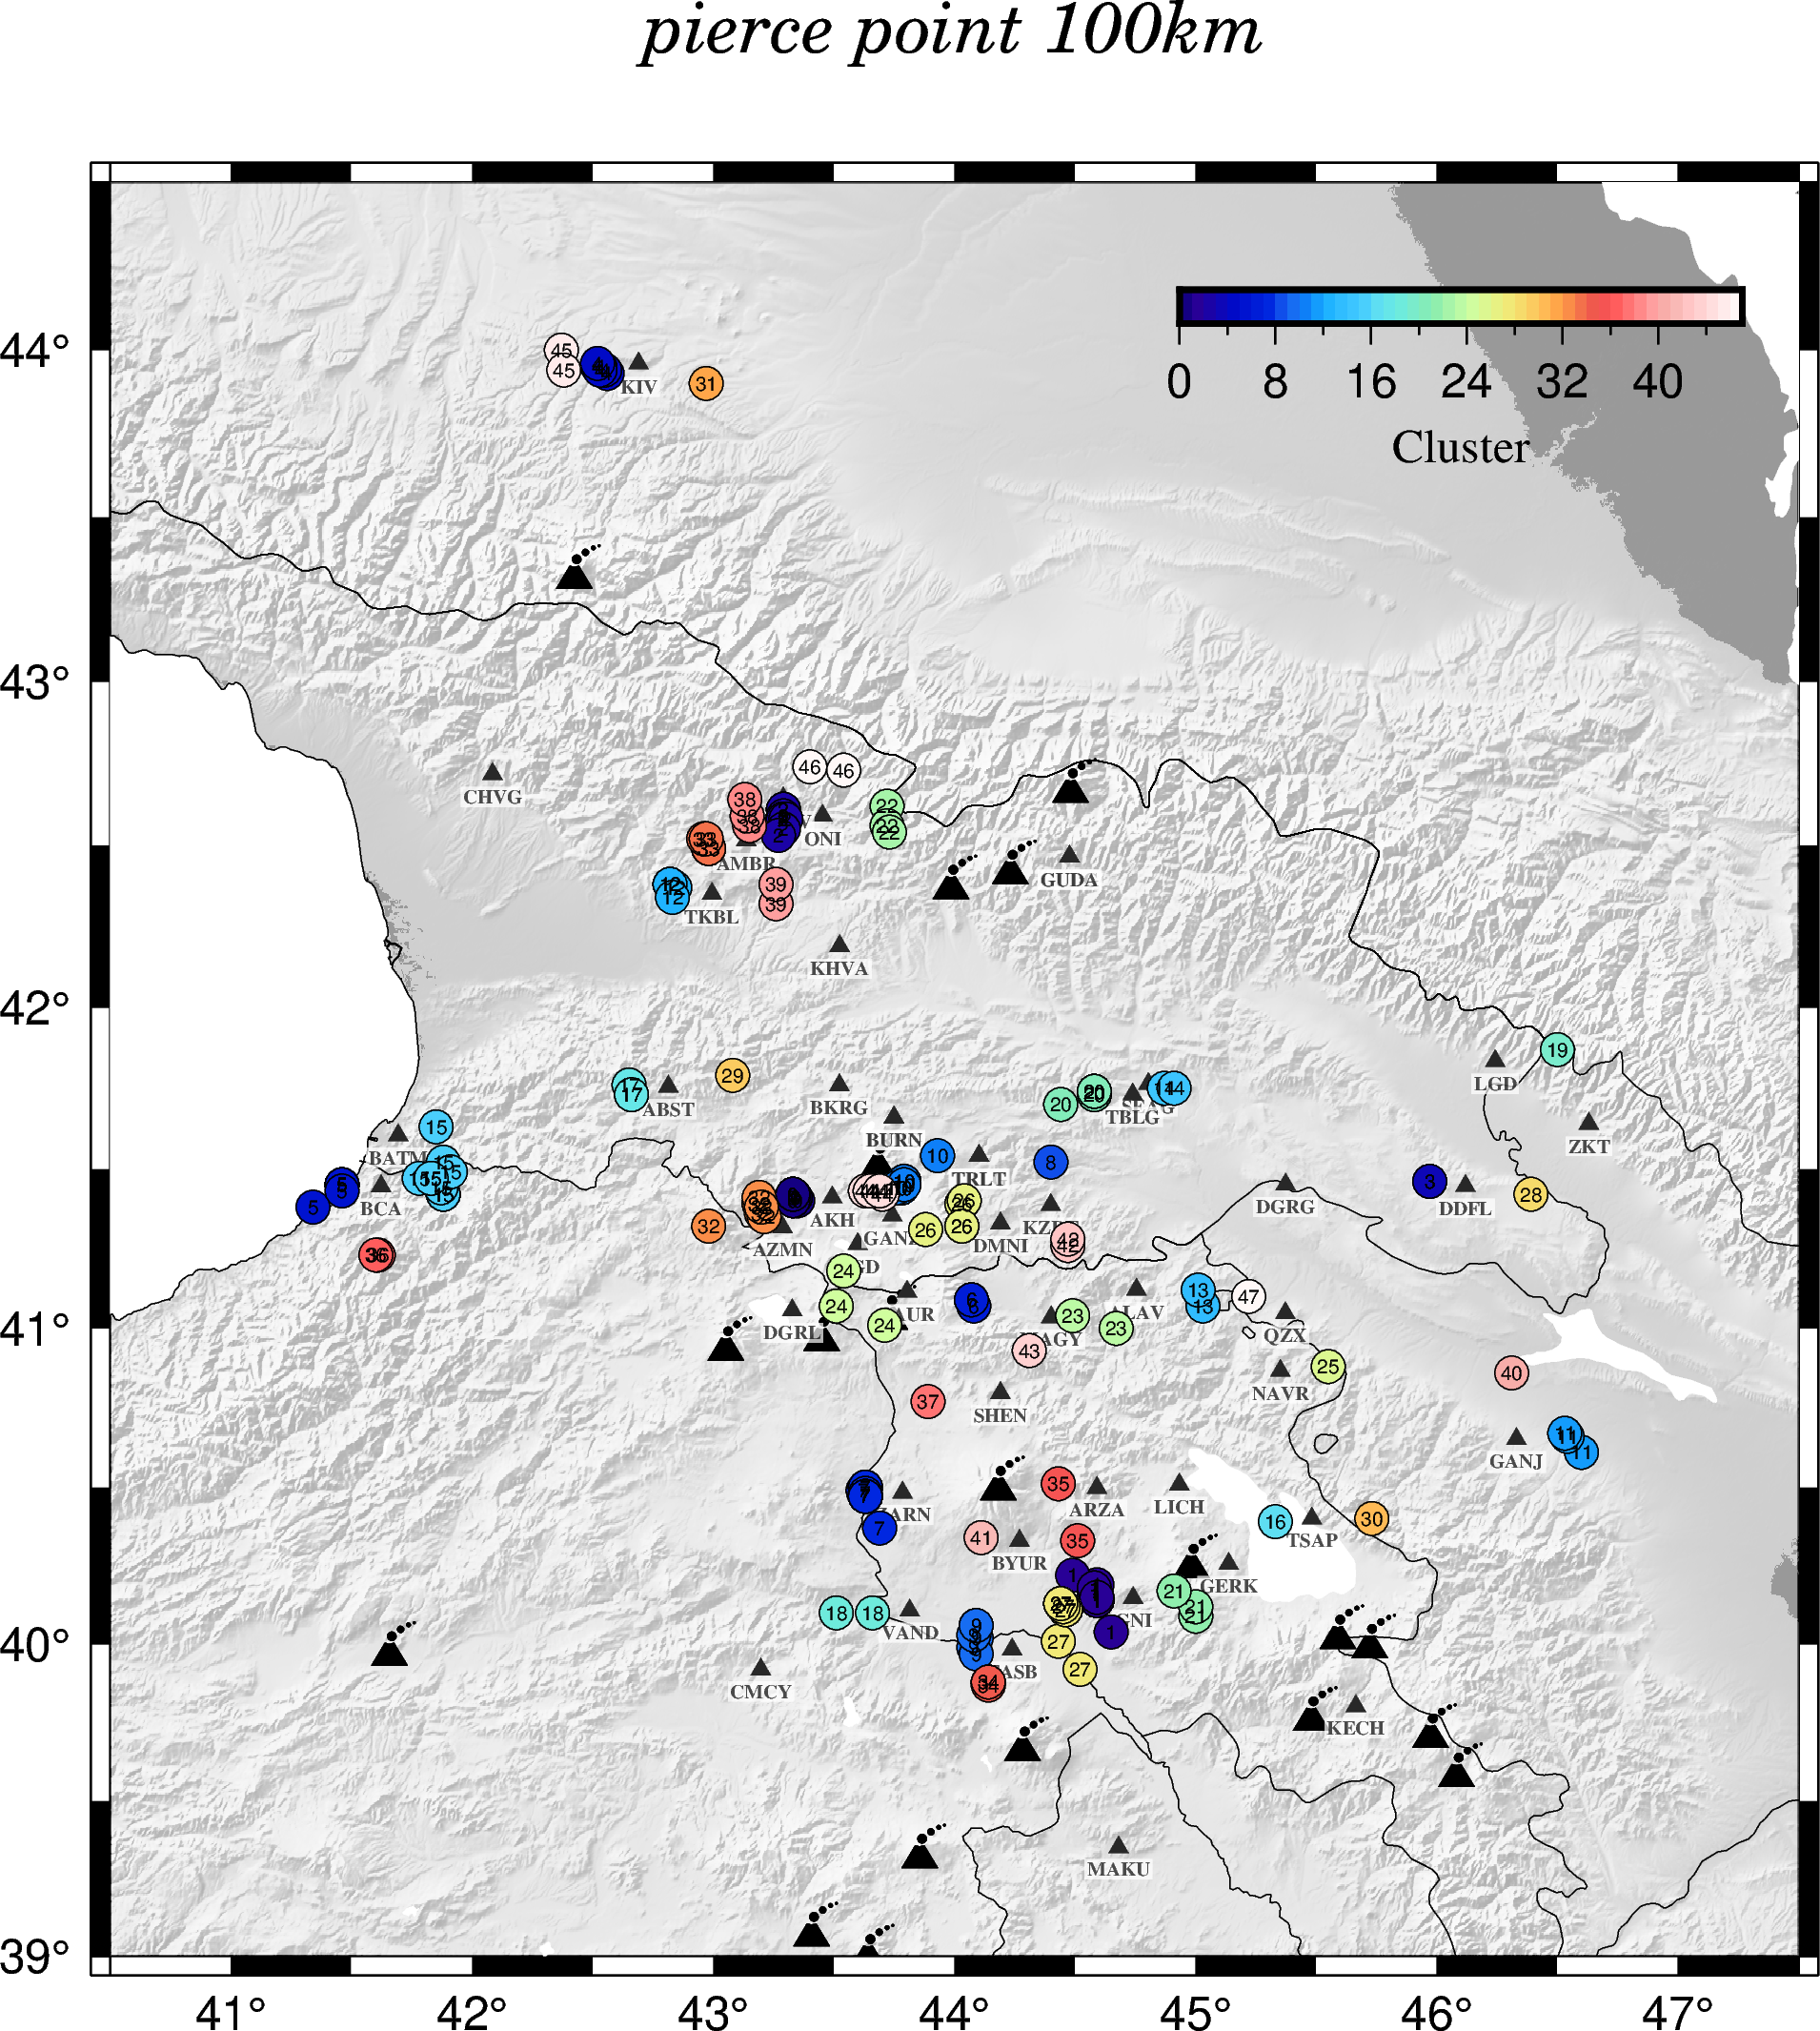

In [11]:
region = [40.5, 47.5, 39, 44.5]
figmap = pygmt.Figure()
title = f"pierce point {PPdepth}km"
PygmtBegin(figmap,region,title)
maxclu = max(df['cluster'])
for pkl in sorted(glob.glob(f'{PKLpath}/*.pkl')):
    STApkl = pickle.load(open(pkl, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    sta = values['station'];net = values['network']
    stlat = values['latitude']; stlon = values['longitude']
    figmap.plot(x=stlon, y=stlat, style="t0.1c", color='70', pen="1.5p,40")
    figmap.text(x=stlon,y=stlat-0.07,text=sta, font="5p,Times-Bold,black",fill='white',transparency=30)
qqq=pygmt.makecpt(cmap="haxby", series=[0, maxclu, 1 ], continous=False, output='qqq.cpt')
figmap.plot(x=df['plon'], y=df['plat'], 
            style='c0.3c', color=df['cluster'], 
            cmap='qqq.cpt', pen="black")
figmap.text(x=df['plon'], y=df['plat'], text = df['cluster'], font='5p')
figmap.colorbar(cmap='qqq.cpt', position="x9.5c/14.5c+w5c/0.3c+h",frame=["a8f4", "x+lCluster"])
figmap.savefig(f'{figpath}/non-null/Cluster{PPdepth}/ClusterMap.png',dpi=200)
figmap.savefig(f'{figpath}/non-null/Cluster{PPdepth}/ClusterMap.pdf')
figmap.show()

In [7]:
def angle_mean(dt, phi):
    import numpy as np
    dt=np.array(dt)
    phi=np.array(phi)
    x = dt*np.cos(2*phi*np.pi/180.0)
    y = dt*np.sin(2*phi*np.pi/180.0)
    c = x + 1j*y
    m = np.mean(c)

    phase = np.angle(m, deg=True)/2.
    radius = np.abs(m)

    return phase, radius

In [8]:
region = [40.5, 47.5, 39, 44.5]
maxclu = max(df['cluster'])

for i in range(maxclu):
    figmap = pygmt.Figure()
    title = f"pierce point {PPdepth}km-Cluster{i}"
    PygmtBegin(figmap,region,title)
    figmap.plot(x=df['plon'], y=df['plat'], style='c0.15c', color='140', pen="black")
    
    dff = df[df['cluster']==i]
    length = len(dff)
    if length>0:
        for j in range(len(dff)):
            sta = dff['station'].values[j]
            phi = dff['phi'].values[j]
            dt  = dff['dt'].values[j]
            phase = dff['phase'].values[j]
            p_lon = dff['plon'].values[j]
            p_lat = dff['plat'].values[j]

            if phase == 'SKS': color = 'red3'
            elif phase == 'SKKS': color = 'violet'

            if sta == 'CMCY' or sta == 'DGRL' or sta =='MAKU' :
                color = 'purple2'    
            data = [[p_lon, p_lat, phi-90, 3, dt*40]]
            figmap.plot(data=data, style="J", color=color, pen="0.5p,black",transparency=35, no_clip=True)

        avg_phi, avg_dt = angle_mean(dff['dt'], dff['phi'])
        avg_phi = int(avg_phi)
        figmap.text(x=45.7, y= 42.9, text=f'Cluster {i}, Num:{length}', font='15p,5,black',justify='BC' )
        figmap.rose(length=dff['dt'],
                 azimuth=dff['phi'],
                 region=[0, 1, -90, 90],
                 diameter="5.5c",
                 sector="10",
                 labels = 'W,E,-,N',
                 norm=True,
                 color="red@50",
                 frame=['xg0.5',"y30g30", "+gwhite"],
                 pen="v2p,red3", 
                vectors = '+wmode_file',
                vector_params='0.7c+e+gred3+h0.5',
                xshift='3.3i', yshift='4.6i')
        if avg_phi >0:
            figmap.text(position="MR", text=f'{int(avg_phi)}',font='18p,5,red=0.8p,black,solid')  

        else:
            figmap.text(position="ML", text=f'{int(avg_phi)}',font='18p,5,red=0.8p,black,solid')

        figmap.savefig(f'{figpath}/non-null/Cluster{PPdepth}/Cluster{i}.png',dpi=200)
        figmap.savefig(f'{figpath}/non-null/Cluster{PPdepth}/Cluster{i}.pdf')    
        print(f'=================Cluster{i} finish')


KeyboardInterrupt: 

In [13]:
cluster = [7,17,37]
philist = []
dtlist  = []
for cc in cluster:
    dff = df[df['cluster']==cc]
    for ii in range(len(dff)):
        phi = dff['phi'].values[ii]
        dt = dff['dt'].values[ii]
        philist.append(phi)
        dtlist.append(dt)
    
avg_phi, avg_dt = angle_mean(dtlist, philist)
print(avg_phi, avg_dt)

33.1742120513 1.50154202735


In [14]:
clusdf = {'Cluster':[],
          'length':[],
         'clon':[],
         'clat':[],
         'meanphi':[],
         'meandt':[]  }
maxclu = max(df['cluster'])

for i in range(maxclu):
    
    dff = df[df['cluster']==i]
    length = len(dff)
    Clon = np.mean(dff['plon'])
    Clat = np.mean(dff['plat'])

    avg_phi, avg_dt = angle_mean(dff['dt'], dff['phi'])
    avg_phi = int(avg_phi)
    
    clusdf['Cluster'].append(i)
    clusdf['length'].append(length)
    clusdf['clon'].append(Clon)
    clusdf['clat'].append(Clat)
    clusdf['meanphi'].append(avg_phi)
    clusdf['meandt'].append(avg_dt)
    
    print(f'=================Cluster{i} finish')
clusdf = pd.DataFrame(clusdf)
clusdf.to_csv(f'{figpath}/non-null/Cluster{PPdepth}/01_Cluster_mean.csv',index=False )
print(f'{figpath}/non-null/Cluster{PPdepth}/01_Cluster_mean.csv')

=================Cluster0 finish
=================Cluster1 finish
=================Cluster2 finish
=================Cluster3 finish
=================Cluster4 finish
=================Cluster5 finish
=================Cluster6 finish
=================Cluster7 finish
=================Cluster8 finish
=================Cluster9 finish
=================Cluster10 finish
=================Cluster11 finish
=================Cluster12 finish
=================Cluster13 finish
=================Cluster14 finish
=================Cluster15 finish
=================Cluster16 finish
=================Cluster17 finish
=================Cluster18 finish
=================Cluster19 finish
=================Cluster20 finish
=================Cluster21 finish
=================Cluster22 finish
=================Cluster23 finish
=================Cluster24 finish
=================Cluster25 finish
=================Cluster26 finish
=================Cluster27 finish
=================Cluster28 finish
=================Cluster

47


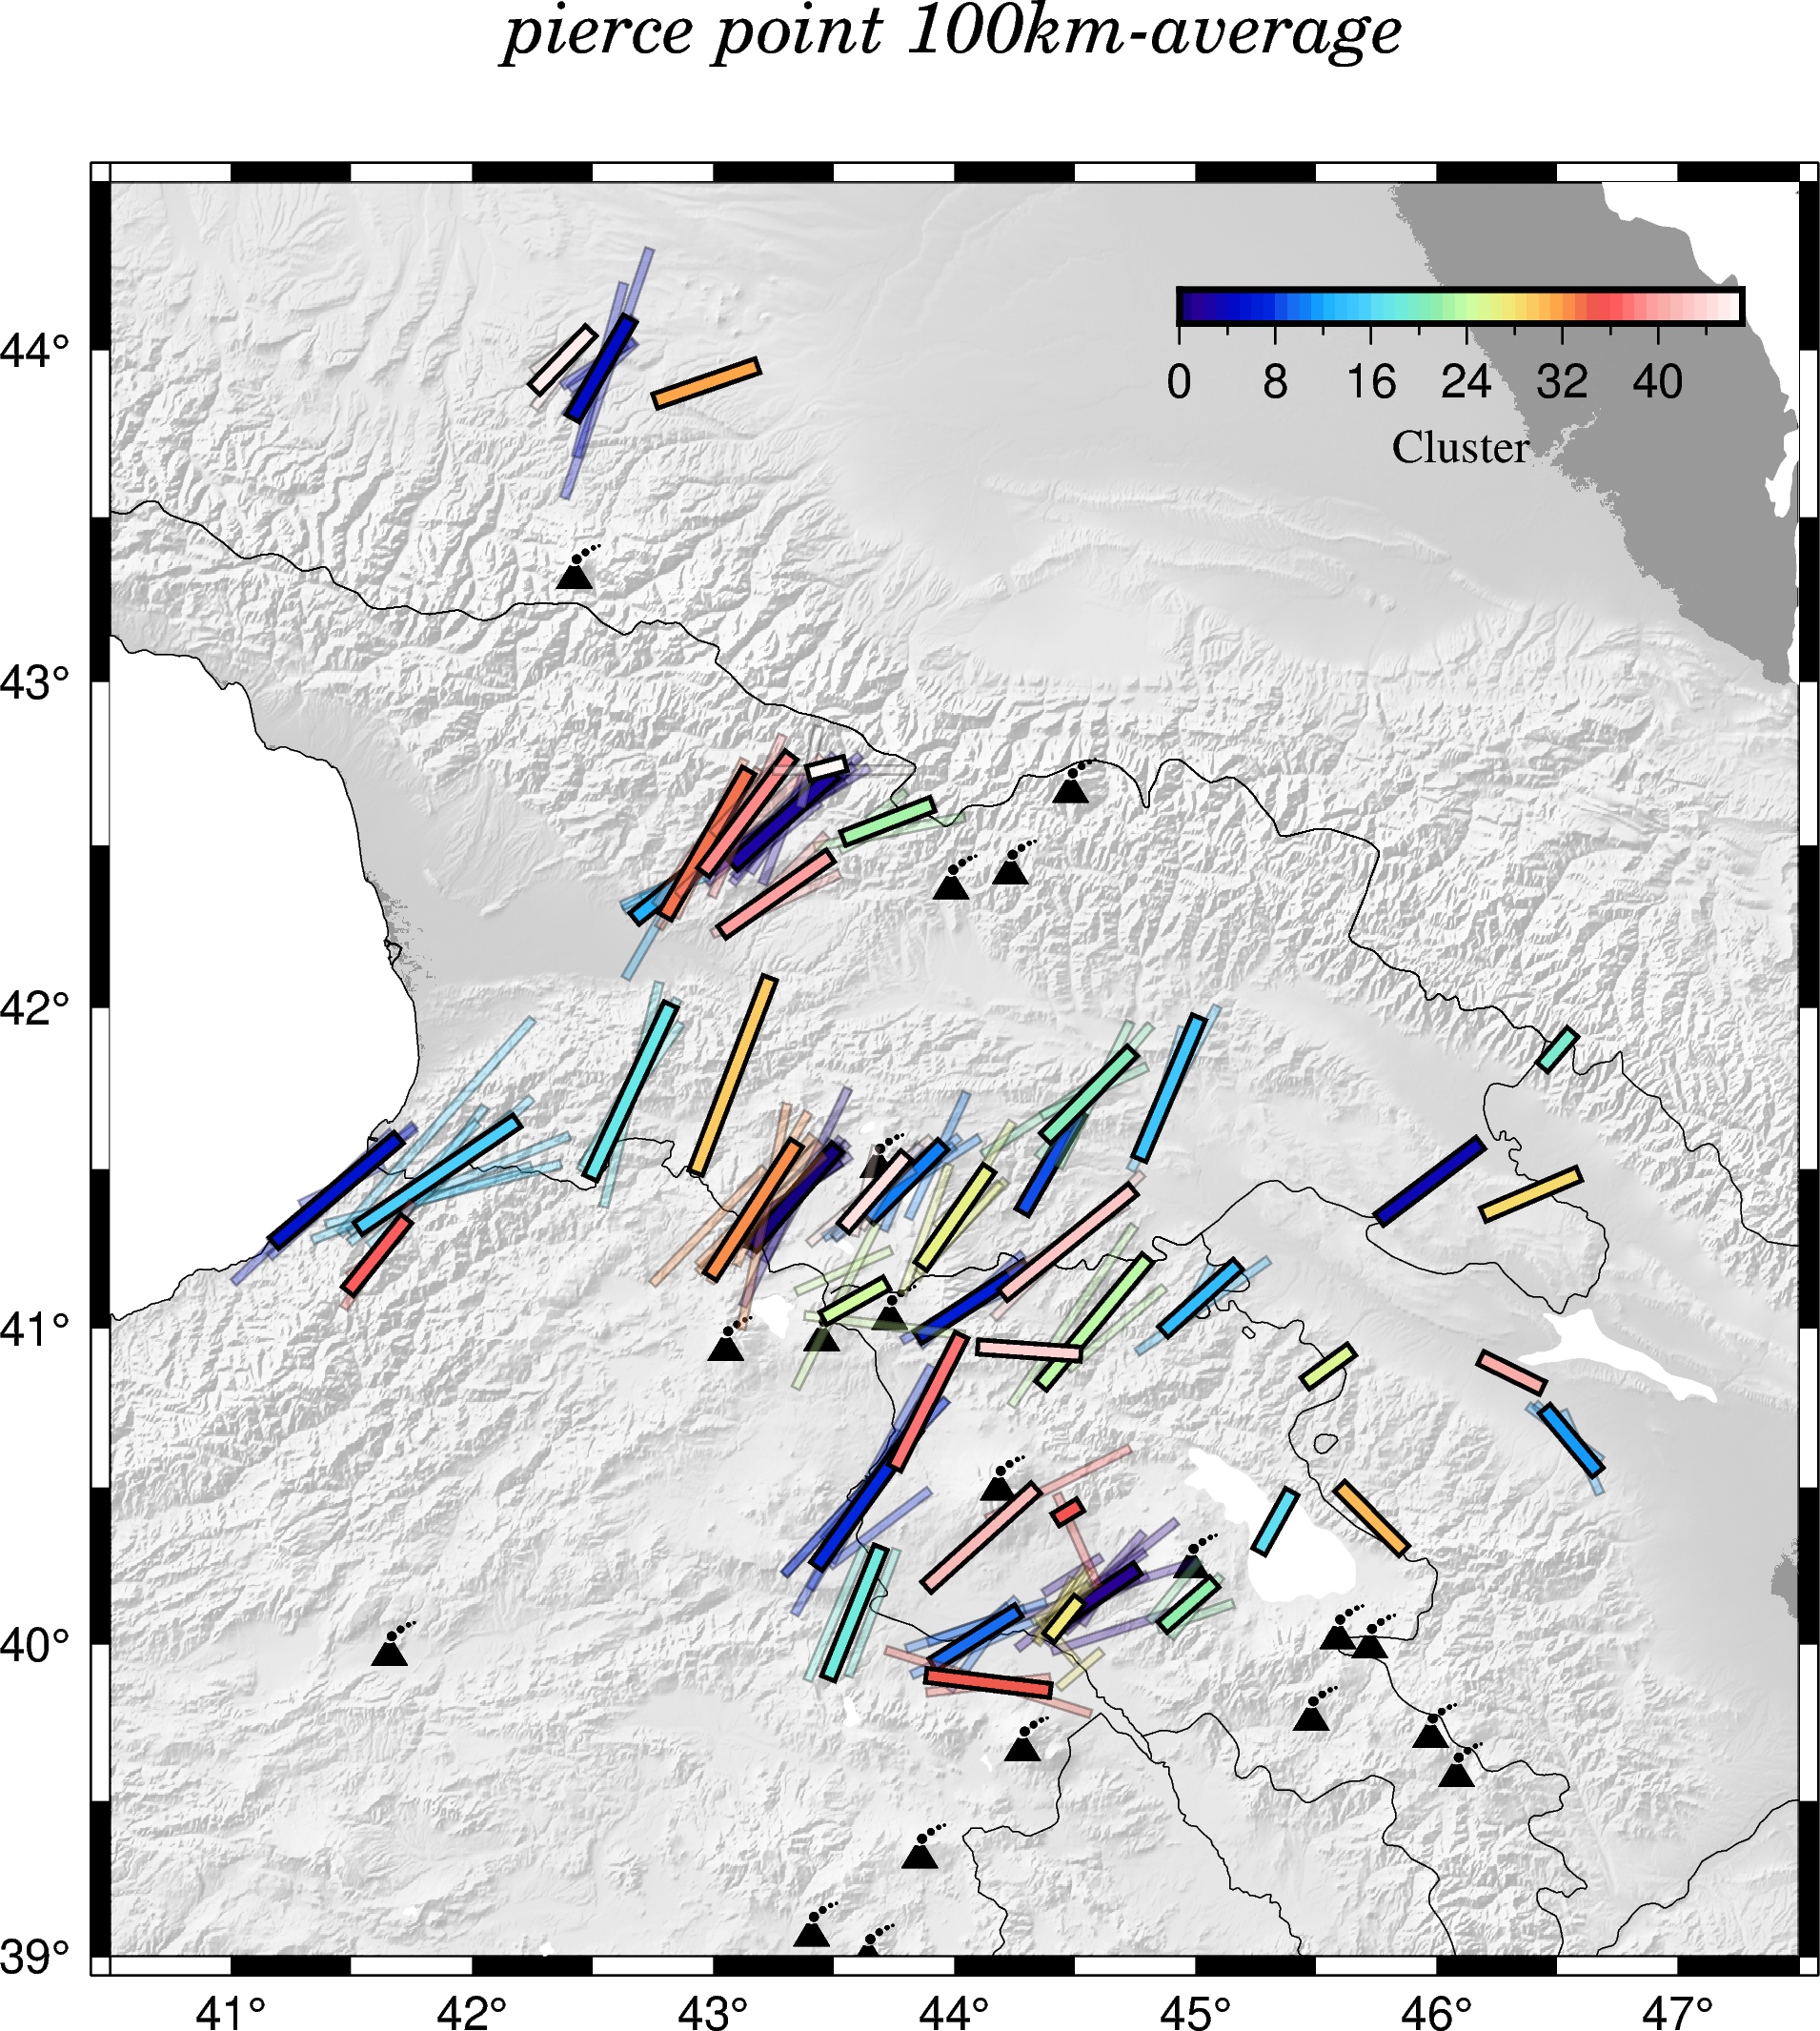

In [15]:
df = pd.read_csv(f'{figpath}/non-null/PP{PPdepth}.csv')
qqq=pygmt.makecpt(cmap="haxby", series=[0, maxclu, 1 ], continous=False, output='qqq.cpt')
dcolor = pd.read_csv('qqq.cpt', sep='\s+', names = ['begin', 'color1', 'end', 'color2','q'])
dclu   = pd.read_csv(f'{figpath}/non-null/Cluster{PPdepth}/01_Cluster_mean.csv')
region = [40.5, 47.5, 39, 44.5]
title = f"pierce point {PPdepth}km-average"
figmap = pygmt.Figure()
PygmtBegin(figmap,region,title)
maxclu = max(df['cluster'])
print(maxclu)
for i in range(maxclu):
    dff = df[df['cluster']==i]
    length = len(dff)
    color = dcolor['color1'][dcolor['begin']==str(i)].values[0]
    for j in range(len(dff)):
        sta = dff['station'].values[j]
        phi = dff['phi'].values[j]
        dt  = dff['dt'].values[j]
        phase = dff['phase'].values[j]
        p_lon = dff['plon'].values[j]
        p_lat = dff['plat'].values[j]
   
        data = [[p_lon, p_lat, phi-90, 3, dt*40]]
        figmap.plot(data=data, style="J", color=color, pen="0.5p,black",transparency=70, no_clip=True)

    cclon = dclu['clon'][dclu['Cluster']==i].values[0]
    cclat = dclu['clat'][dclu['Cluster']==i].values[0]
    ccphi = dclu['meanphi'][dclu['Cluster']==i].values[0]
    ccdt = dclu['meandt'][dclu['Cluster']==i].values[0]
    ccdata = [[cclon, cclat, ccphi-90, 5, ccdt*40]]
    figmap.plot(data=ccdata, style="J", color=color, pen="1p,black", no_clip=True)

figmap.colorbar(cmap='qqq.cpt', position="x9.5c/14.5c+w5c/0.3c+h",frame=["a8f4", "x+lCluster"])
figmap.savefig(f'{figpath}/non-null/Cluster{PPdepth}/01_Cluster_phi_v2.png',dpi=200)
figmap.savefig(f'{figpath}/non-null/Cluster{PPdepth}/01_Cluster_phi_v2.pdf')
figmap.show()

# fun

In [ ]:
points1 = pygmt.project(center=[40.9,42.7], endpoint=[47.25, 40.7], generate=0.05,unit=True)

In [ ]:


def find_closest(lat, lon):
    mindist=10000
    mink=0
    for k, info in enumerate(zip(points1['r'], points1['s'])):
        plon = info[0]
        plat = info[1]
        dist, az, baz = gps2dist_azimuth(plat, plon, lat, lon)
        dist/=1000
        if dist < mindist:
            mindist = dist
            mink = k
        
    
    closelon = points1['r'].values[mink]
    closelat = points1['s'].values[mink]  
    closedist = points1['p'].values[mink]  
#     print(closelon, closelat)
    return closelon, closelat, closedist
    

In [ ]:
LC = [22,14,29,6,20,42,48,1,47,16,17,43,10,15,26,35,18] 

dclu = pd.read_csv(f'{figpath}/non-null/Cluster/01_Cluster_mean.csv')
plt.figure(figsize=(7,5))
plt.suptitle('Lesser Caucasus variation', fontsize=15, fontweight='bold')
plt.subplot(211)
plt.hlines(y=50,xmin=0, xmax=560,color='lightgrey',linestyle='--', lw=1)
plt.subplot(212)
plt.hlines(y=1,xmin=0, xmax=560,color='lightgrey',linestyle='--', lw=1)

for i in LC:
    dcc = dclu[dclu['Cluster']==i]
    
    clon= dcc['clon'].values[0]
    clat= dcc['clat'].values[0]
    phi = dcc['meanphi'].values[0]
    dt  = dcc['meandt'].values[0]
    
    closelon, closelat, closedist = find_closest(clat, clon)
    plt.subplot(211)
    plt.scatter(closedist,phi, marker='o', color='k', s=15)
    plt.ylabel('Fast direction (°)', fontsize=13)
    plt.xlim(0,560)
    plt.ylim(-90,90)
    plt.xticks(range(0,560,50))
    plt.yticks(range(-90,91,30))
    plt.subplot(212)
    plt.scatter(closedist,dt, marker='o', color='k', s=15)
    plt.xlim(0,560)
    plt.ylim(0,2)
    plt.xticks(range(0,560,50))
    plt.yticks(np.arange(0,2.1,0.5))
    plt.ylabel('Delay time (s)', fontsize=13)
    plt.xlabel('Distance (km)', fontsize=13)

plt.savefig(f'{figpath}/non-null/Cluster/02_LC_variation.png',dpi=200)
plt.savefig(f'{figpath}/non-null/Cluster/02_LC_variation.pdf')    